In [172]:
# Se importan librerias necesarias para el analisis
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from shapely.geometry import Polygon
import shapely
import rasterio
import rasterio.merge
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from scipy.ndimage import convolve
import numpy as np
import matplotlib.pyplot as plt
import json

## 5.1 Attribute Data Operations
- Filter entities based on specific attributes (e.g., select agricultural areas with a slope < 10% and close to rivers).

In [2]:
# Se carga el archivo
gdf = gpd.read_file('vector/LA_UNION_VALLE.gpkg')
# Se guardan los indices las filas que contienen menos de 100 de Area
indice_areas_pequeñas = gdf['AREA_HA'] < 100
# Se guardan los indices de las filas que solamente sean pastos limpios (Leyenda 2.3.1)
indice_cobertura = gdf['leyenda'] == '2.3.1. Pastos limpios' 
# Se filtra el dataframe a partir de la leyenda y el area 
filtred_gdf=gdf.loc[indice_areas_pequeñas & indice_cobertura, ['leyenda', 'AREA_HA']]
# Se muestran primeras 5 filas del dataframe filtrado
filtred_gdf.head(5)

,leyenda,AREA_HA
0,2.3.1. Pastos limpios,0.000000e+00
1,2.3.1. Pastos limpios,2.945110e+00
2,2.3.1. Pastos limpios,0.000000e+00
3,2.3.1. Pastos limpios,2.612981e+00
6,2.3.1. Pastos limpios,1.514779e-09


- Group data by a categorical attribute (e.g., land use type) and summarise other attributes like area or population. 

In [3]:
# Se agrupa por la variable de usos recomendados y se saca la suma del area de cada uso 
summary = gdf.groupby('USOS_RECOM').agg(
    total_area_ha=('AREA_HA', 'sum'),  # Suma de las áreas en hectáreas
    count=('USOS_RECOM', 'count')  # Número de entidades por tipo de uso del suelo
).reset_index()

#Se muestran las primeras 5 filas de las estadisticas de cada uso recomendado
summary.head(5)

,USOS_RECOM,total_area_ha,count
0,"Agricultura con cultivos de algodón, soya, frí...",83.996600,23
1,Agricultura con cultivos de arroz o caña de az...,512.093450,28
2,Agricultura con cultivos de caña de azúcar o a...,1816.496795,74
3,"Agricultura con cultivos de caña de azúcar, so...",1516.744994,120
4,"Agricultura con cultivos de soya, ajonjolí, fr...",287.410478,26


- Merge geometries and summarise data by a grouping attribute (e.g., dissolve administrative boundaries into regions).

In [4]:
# Se disuelve por el atributo leyenda y los valores se agregan a partir de la suma
gdf_dissolved = gdf.dissolve(by='leyenda', aggfunc='sum')
gdf_dissolved.head(1)

,geometry,UCS_CP,CLASE,SUBCLASE,UCS,PRINCIPALE,USOS_RECOM,PRACTICAS_,CODIGO_VER,NOMBRE_VER,...,CLIMA,TIPO_RELIE,FORMA_TERR,LITOLOGÍA,CARACTERÍ,COMPONENTE,PERFIL,AREA_HA,X,Y
leyenda,,,,,,,,,,,,,,,,,,,,,
1.1.1. Tejido urbano continuo,"POLYGON ((-76.10602 4.52874, -76.10667 4.52894...",VIes-1VIes-1VIes-1VIes-1VIes-1VIIpe-16VIes-1VI...,VIVIVIVIVIVIIVIVIIIIVIIVIVIVIVIZUZUZUZUZUZUVIV...,esesesesespeeseshspessssZUZUZUZUZUZUesesespeps...,"SJb2, SJc2SJb2, SJc2SJb2, SJc2SJb2, SJc2SJb2, ...","Erosión moderada, profundidad efectiva muy sup...",Sistemas agrosilvopastoriles con cultivos de m...,"Control de la erosión, ruptura de materiales c...",7640001976400023764000027640002976400029764000...,PAJARO DE OROEL LUCEROEL RINCÃ“NEL GUASIMOEL G...,...,Cálido secoCálido secoCálido secoCálido secoZo...,Abanico coluvio-aluvialAbanico coluvio-aluvial...,ÁpiceÁpiceÁpiceÁpiceZona urbanaN/AÁpiceÁpiceCu...,Aluviones finosAluviones finosAluviones finosA...,Muy superficiales limitados por material compa...,"Consociación: Vertic Haplustalfs, fina, esmect...",V91V91V91V91Zona urbanaPO-36V91V91V26PO-36V91;...,247.559434,-2511.331913,149.517248


## 5.2. Spatial Operations

### 5.2.1. Spatial Relationships and Selection

- Select entities based on their spatial relationship: e.g.  Identify urban areas within a conservation zone.

In [5]:
# Se carga el shapefile de suelos que contiene informacion de clima en la region
path_shp_clima="vector/estudio_suelos_la_union/Estudio_suelos_la_union.shp"
df_clima = gpd.read_file(path_shp_clima)
# Se carga el shapefile donde se encuentran las delimitaciones de los corregimientos
path_shp_correg="vector/corregimientos_la_union/corregimientos_la_union.shp"
df_correg = gpd.read_file(path_shp_correg)

# Se igualan los sistemas de coordenadas
if not df_clima.crs == df_correg.crs:
    df_clima = df_clima.to_crs(df_correg.crs)

# Se hace una union de los dataframes teniendo en cuenta solo las geometrias que coinciden
clima_por_corregimiento = gpd.sjoin(df_clima, df_correg, how="inner", predicate="within")

# Se seleccionan filas a partir de las nuevas relaciones entre atributos que se han generado
selected_df = clima_por_corregimiento[(clima_por_corregimiento['NOM_DIV_PO'] == 'San Luis') &(clima_por_corregimiento['CLIMA'] == 'Cálido seco')]
selected_df.loc[:,['NOM_DIV_PO','CLIMA']]


,NOM_DIV_PO,CLIMA
9,San Luis,Cálido seco
11,San Luis,Cálido seco
14,San Luis,Cálido seco
16,San Luis,Cálido seco
18,San Luis,Cálido seco
19,San Luis,Cálido seco
20,San Luis,Cálido seco


- Identify entities that intersect with another layer. e.g. Rivers intersecting with hazard zones.

<Axes: >

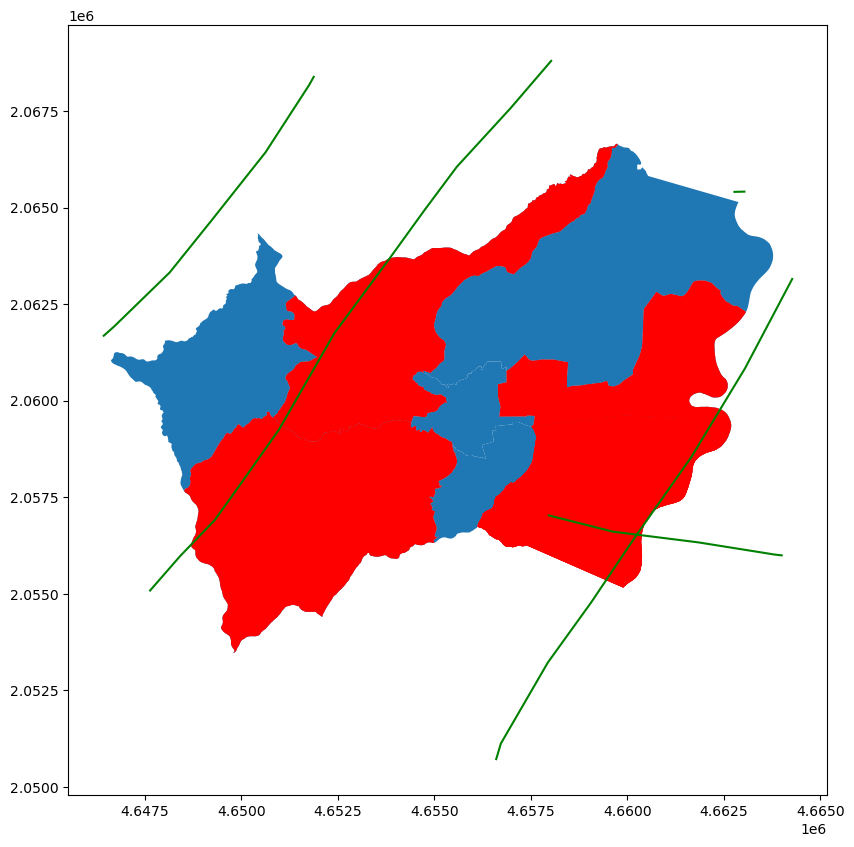

In [6]:
# Se carga el archivo shapefile donde se encuentran datos de geologia
df_geol=gpd.read_file("vector/Geologia_estructural/Geologia_estructural.shp")

# Se iguala el sistema de coordenadas
if not df_geol.crs == df_correg.crs:
    minas_points = df_geol.to_crs(df_correg.crs)

# Se hace una interseccion entre el corregimiento seleccionado y la geologia
df_filtred=gpd.sjoin(df_correg, df_geol, how="inner", predicate="intersects")

# Se hace el grafico de aquella zonas que se interceptadas 
fig, ax = plt.subplots(figsize=(10, 10))
df_correg.plot(ax=ax)
df_geol.plot(ax=ax,color='green')
df_filtred.plot(ax=ax,color='red')


### 5.2.2. Areas of influence
- Create influence zones (buffer) around points or lines, such as rivers or roads.
- Use the buffer to identify affected areas. e.g. Determine agricultural areas impacted by road buffers.

In [7]:
# Se carga el shapefile que contiene el poligono de todo el municipio
union=gpd.read_file("vector/croquis_la_union.shp")

# Se quiere saber cuales predios del municipio de La Union pueden ser afectados por mineria

# Zonas de mineria
mineria=gpd.read_file("vector/Recurso_Minero_La_Union")
# Predios del municipio
pred=gpd.read_file('vector/terreno_de_predio_rural_igac_la_union')


# Se hace un buffer para los puntos de mineria
mineria_buffered=mineria.buffer(500)
# Los puntos con buffer son guardados como Geodataframe
mineria_buffered_gdf = gpd.GeoDataFrame(geometry=mineria_buffered)
# Se seleccionan solo aquellos predios que se intersecan con las zonas (buffer) de mineria
affected_predios = pred[pred.geometry.intersects(mineria_buffered_gdf.unary_union)]


/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1541/3526407008.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  affected_predios = pred[pred.geometry.intersects(mineria_buffered_gdf.unary_union)]


/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1541/4255451771.py:8: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


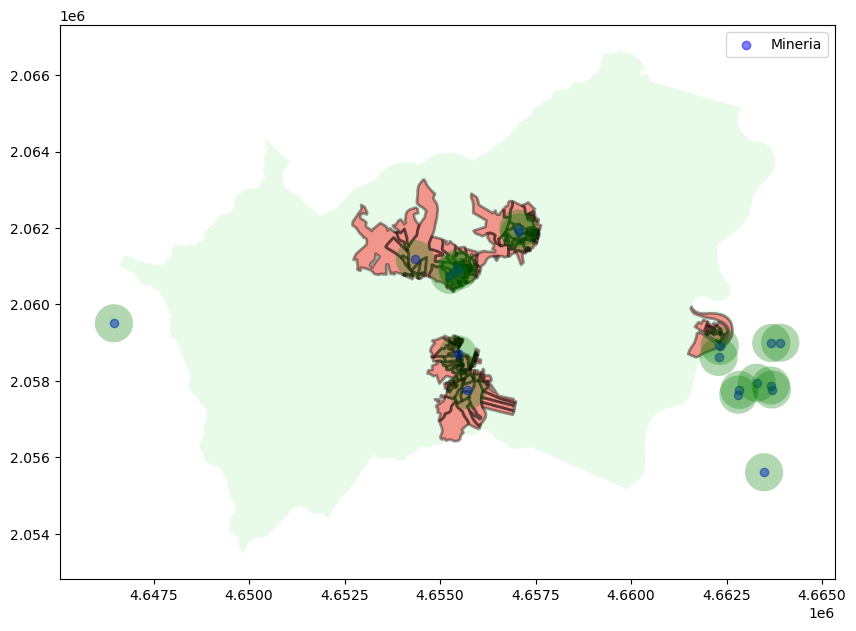

In [8]:
# Se grafican aquellos predios afectados junto a los puntos donde hay mineria
fig, ax = plt.subplots(figsize=(10, 10))
union.plot(ax=ax, color='lightgreen', alpha=0.2, label='Municipio')
affected_predios.plot(ax=ax, color='red', edgecolor='black', linewidth=2, alpha=0.4, label='Predios Afectados')
mineria.plot(ax=ax, color='blue', alpha=0.5, label='Mineria')
mineria_buffered.plot(ax=ax, color='green', alpha=0.3, label='Buffer Zone')

plt.legend()
plt.show()

### 5.2.3. Overlay operations
- Combine two vector layers (e.g., conservation areas and hazard zones) to generate a new layer with the intersection.

              CODIGO SECTOR_COD   NOMBRE     CODIGO_ANT  \
0  76400000100000002  764000001  CORCEGA  7640000010002   

                                 GLOBALID  RULEID  SHAPE_AREA_1   SHAPE_LEN_1  \
0  {E76D4D7F-72C8-4B4C-9966-1F3495DF29AE}       0  7.468662e+06  19935.437024   

  COD_DEPART COD_MUNICI NOM_MUNICI COD_DIV_PO          NOM_DIV_PO  \
0         76      76400   La Union   76400013  Cabecera Municipal   

                      CLASE_DIV_ FUENTE  ANNO_DIV_E  ANNO_AJUST  SHAPE_AREA_2  \
0  Cabecera Municipal Zona Rural   None        2010        2022  4.258779e+06   

   SHAPE_LEN_2                                           geometry  
0  11519.25641  MULTIPOLYGON (((4657518.319 2059345.497, 46575...  


/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1541/2143362979.py:11: UserWarning: `keep_geom_type=True` in overlay resulted in 128 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  gdf_intersection = gpd.overlay(gdf_veredas, gdf_correg,how='intersection')
/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1541/2143362979.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


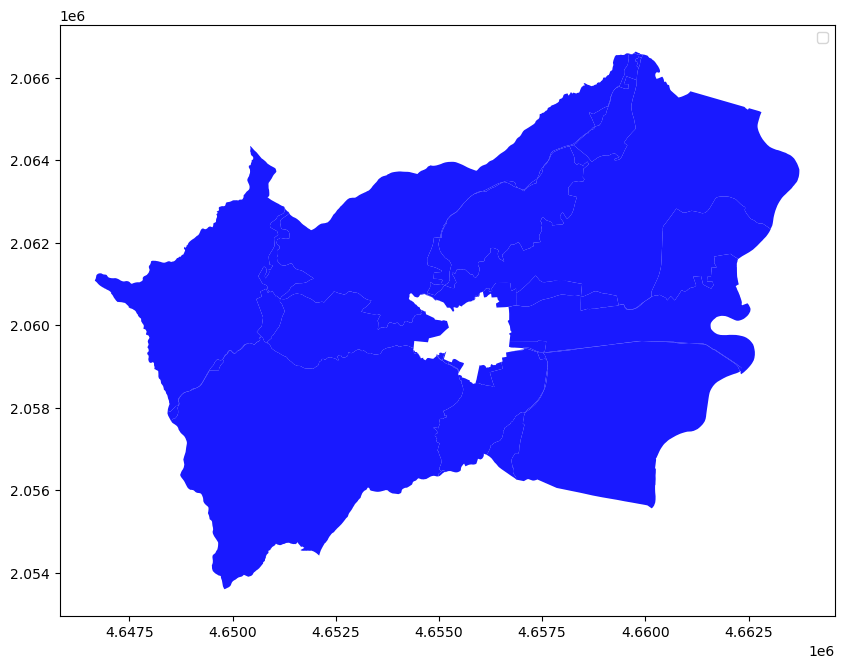

In [9]:
# Se carga shapefile de veredas
gdf_veredas = gpd.read_file('vector/vereda_rural/Vereda_Rural_IGAC.shp') 
# Se carga shapefile de corregimientos
gdf_correg = gpd.read_file('vector/corregimientos_la_union/corregimientos_la_union.shp') 

# Se iguala el sistema de coordenadas
if not gdf_veredas.crs == gdf_correg.crs:
    gdf_veredas = gdf_veredas.to_crs(gdf_correg.crs)
    
# Se realiza la intersección entre las dos capas (Quedan solamente las geometrias que se encuentran en ambas capas)
gdf_intersection = gpd.overlay(gdf_veredas, gdf_correg,how='intersection')

# Se enseña la primera fila de la capa creada a partir de la interseccion de las dos capas 
print(gdf_intersection.head(1))

# Se enseña el mapa resultante de la intersección
fig, ax = plt.subplots(figsize=(10, 10))
gdf_intersection.plot(ax=ax, color='blue', alpha=0.9)
plt.legend()
plt.show()

- Identify parts of a layer not overlapping with another. e.g.Conservation zones outside urban areas.

/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1541/4049880201.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 38 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  difference_layer = gpd.overlay(gdf_correg,gdf_veredas, how="difference")
/var/folders/j9/v4x3hnqx5mx5xp1r2572v97c0000gn/T/ipykernel_1541/4049880201.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


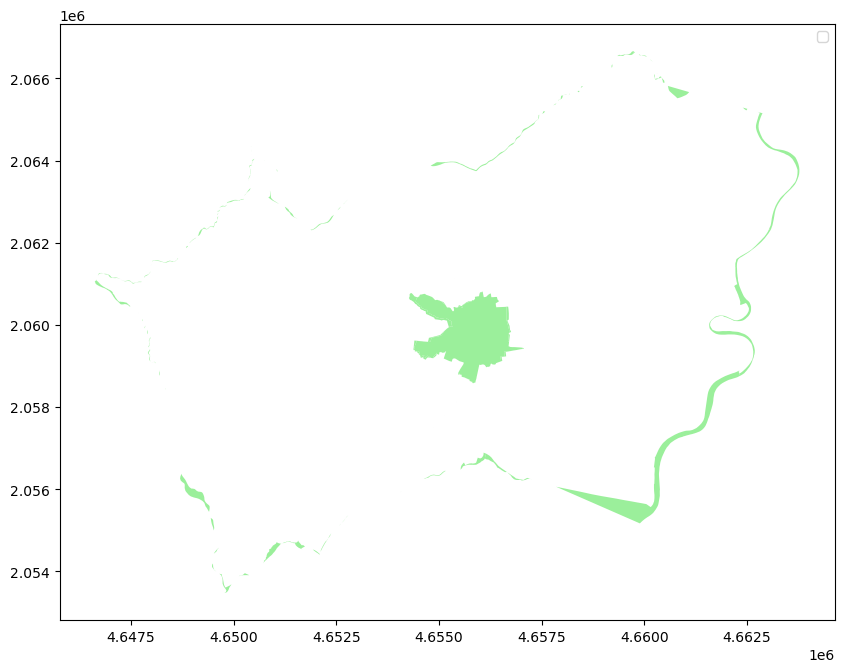

In [10]:
# Se seleccionan las areas donde no se sobreponen ambos poligonos
difference_layer = gpd.overlay(gdf_correg,gdf_veredas, how="difference")
fig, ax = plt.subplots(figsize=(10, 10))
#Se enseñan dichas areas en el mapa
difference_layer.plot(ax=ax, color='lightgreen', alpha=0.9)

plt.legend()
plt.show()

### 5.2.4. Joins
- Perform a spatial join. e.g. Enrich a layer of crop points with attributes from administrative regions.

In [11]:
# Enriquecimiento de veredas con puntos de mineria

# Se cargan los archivos de veredas y mineria
gdf_veredas = gpd.read_file('vector/vereda_rural/Vereda_Rural_IGAC.shp') 
minas_points = gpd.read_file('vector/Recurso_Minero_La_Union')

# Se establece el sistema de coordenadas
if not minas_points.crs == gdf_veredas.crs:
    minas_points = minas_points.to_crs(gdf_veredas.crs)

# Se enriquecen los poligonos de veredas con informacion de puntos de mineria
enriched_points = gpd.sjoin(minas_points,gdf_veredas, how="left", predicate="within")
enriched_points.head(5)


,NOM_REC_MI,ESTADO_SER,CLASE_MINE,TIPO_EXTRA,TITULO_MIN,LICENCIA_A,PROPIETARI,TIPO_TENEN,COD_CUENCA,CODIGO_MUN,...,geometry,index_right,CODIGO,SECTOR_COD,NOMBRE,CODIGO_ANT,GLOBALID,RULEID,SHAPE_AREA,SHAPE_LEN
0,Sin Definir,1101090402,1101090543,1101090602,None,None,NN,None,26247000000,76400,...,POINT (4655713.732 2057753.365),10.0,76400000100000004,764000001,CABECERA MPAL.,7640000010004,{5343B731-ADA5-490E-9743-0E650206CE7B},0.0,5.120773e+06,13930.468907
1,Tejar de Aurelio Gallo,1101090401,1101090525,1101090602,N,N,Aurelio Gallo B,03,26247000000,76400,...,POINT (4657076.785 2061884.088),11.0,76400000200000001,764000002,SAN LUIS,7640000020001,{5386D564-4121-4B71-A429-BADFE414B5B8},0.0,7.021742e+06,23589.668557
2,Ladrillera Palo de Leche,1101090401,1101090525,1101090602,N,N,Ladrillera Palo de Leche,03,26149000000,76403,...,POINT (4663480.757 2055608.475),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cantera La Balastrera,1101090402,1101090543,1101090602,None,None,Osvelio Cordoba,None,26149000000,76403,...,POINT (4663671.076 2058990.999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cantera Via Versalles,1101090401,1101090543,1101090602,N,N,Francisco Javier Blandon,03,26247000000,76400,...,POINT (4654341.432 2061183.037),2.0,76400000200000002,764000002,LA AGUADA,7640000020002,{450EF18D-1C40-4F70-9DC9-3C110D85688E},0.0,1.547816e+07,32376.360304


### 5.2.5. Joining Incongruent Layers
- **Create** a synthetic grid layer of rectangular polygons over the extent of their project data.
- Add unique IDs to each grid cell.
- Calculate the area-weighted proportion for each attribute in the project layer and assign it to the grid.
- Compare the sum of the original attribute (e.g., population) in the project layer with the sum in the grid.

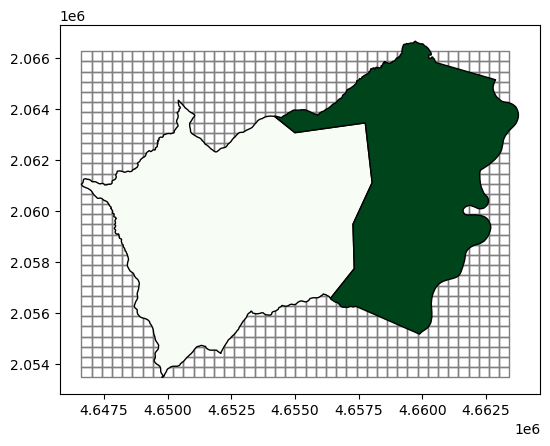

In [64]:
from shapely.geometry import box

# Se carga un archivo donde hay valores de precipitaciones para el municipio
preci=gpd.read_file("vector/prec_nov_union/prec_nov.shp")

# Se extraen los limites municipales
xmin, ymin, xmax, ymax = preci.total_bounds

# Se establece el tamaño de la grilla
cell_size = 400 

# Se calcula el numero de filas y columnas basandose en los limites del municipio
rows = int((ymax - ymin) / cell_size)
cols = int((xmax - xmin) / cell_size)

# Se crea una lista vacia que va a almacenar todas celdas definidas por los vertices x1,y1,x0,y0
grid_cells = []
for i in range(cols):
    for j in range(rows):
        x0 = xmin + i * cell_size
        y0 = ymin + j * cell_size
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        grid_cells.append(box(x0, y0, x1, y1))

# Se crea un GeoDataFrame para la grilla
grid = gpd.GeoDataFrame({'geometry': grid_cells})

# Se le establece el sistema de coordenadas del GeoDataFrame Inicial
grid.set_crs(preci.crs, inplace=True) 


# Se muestran los poligonos de precipitaciones (2) junto a la grilla creada debajo
base = grid.plot(color='none', edgecolor='grey')
preci.plot(
    ax=base, 
    column='VALUE_PROM', 
    edgecolor='black', 
    legend=False, 
    cmap='Greens'
);

<Axes: >

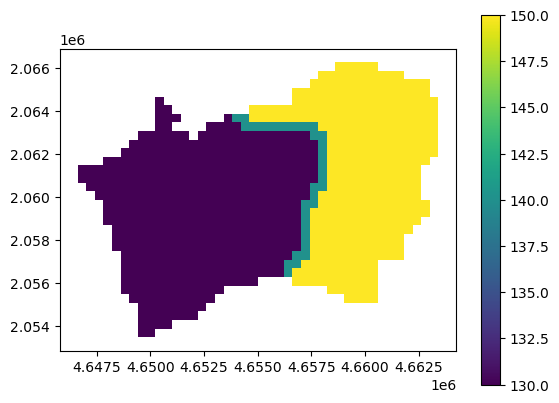

In [65]:
# Cada celda recibe un identificador ID
grid['id'] = range(1, len(grid) + 1)
# Se realiza la interseccion entre la capa original y la grilla creada previamente
intersections = gpd.overlay(preci, grid, how='intersection')

# Se calcula el area de las intersecciones
intersections['intersection_area'] = intersections.geometry.area

# Se calcula la precipitacion media ponderada por area
attributes = ['VALUE_PROM']
for attr in attributes:
    intersections[f'attribut_weighted_{attr}'] = (intersections['VALUE_PROM']*intersections['intersection_area']) / intersections['intersection_area']


# Para cada celda del grid se extrae el valor ponderado medio de las intersecciones
for attr in attributes:
    grid[attr] = grid['id'].map(
        intersections.groupby('id')[f'attribut_weighted_{attr}'].mean()
    )
# Se eliminan valores nulos
grid = grid.dropna(subset=['VALUE_PROM'])
# Se muestran los resultados
grid.plot(column='VALUE_PROM', cmap='viridis', legend=True)


In [89]:
#Sumando los valores de precipitaciones ponderando por area de cada poligono

# Layer original
print((preci['VALUE_PROM']*preci['SHAPE_AREA']).sum())

#Valor de grilla
print((grid['VALUE_PROM']*160000).sum())


425681111329.73
18488000000.0


- **What are incongruent layers, and how do they differ from congruent layers in spatial analysis?** 

Congruent layers are datasets that align perfectly in terms of geographic extent, coordinate reference system (CRS), resolution, and the spatial features they represent. These layers share the same CRS, cover the same area, and have the same resolution, allowing them to be combined or analyzed together without any further transformations.

On the other hand, incongruent layers are spatial layers that do not align perfectly due to differences in CRS, resolution, extent, or the types of spatial features they represent. These layers may need to be reprojected, resampled, or clipped to match each other in terms of spatial properties.
- **Why is it important to address incongruence when aggregating spatial data?** 

Is important because mismatched spatial properties such as differing coordinate reference systems (CRS), resolutions, or geographic extents can lead to inaccuracies and inconsistencies in the analysis results. If layers are incongruent, they cannot be combined or aggregated properly, as their alignment would not reflect true spatial relationships.

- **How does area-weighted interpolation help resolve issues caused by incongruence between layers?** 

It helps resolve issues caused by incongruence between layers adjusting to a common spatial framework while maintaining the spatial integrity of the original data. This method redistributes the values from the source layer to a target grid or layer by taking into account the proportion of each grid cell's area that overlaps with the original data's cells. The result is a more accurate and representative interpolation of values, especially when the layers have different resolutions or when transforming between different spatial units.
- **What are the limitations of using area-weighted interpolation with incongruent layers?** 

One major limitation is the potential loss of precision when aggregating data from high-resolution to low-resolution grids. This process averages data over larger areas, which can blur fine details in the original data, leading to a reduction in spatial accuracy. Additionally, area-weighted interpolation assumes that the data values are uniformly distributed within each grid cell, which may not be true for complex or heterogeneous data. This assumption can result in inaccurate representations, especially in areas with sharp gradients.

Another limitation is the occurrence of edge effects, where data at the boundaries of the interpolated grid may be stretched or misrepresented due to differences in the spatial extent of the layers. Moreover, area-weighted interpolation does not resolve issues related to different coordinate reference systems (CRS) or mismatched extents between layers. Layers with varying CRS or incomplete overlap may require additional preprocessing, such as reprojecting or resampling, before interpolation can be applied correctly. Additionally, for large datasets or when high detail is required, the computational cost of performing area-weighted interpolation can be high, potentially leading to longer processing times and increased resource demands.

### 5.2.6. Topological Relations

- Perform **at least one** of the following operations:
    - Find geometries that share a boundary with a specific feature. Hint:**`touches`**
    - Find geometries that cross others (e.g., roads crossing rivers). **(Hint:`crosses`).**
    - **Identify overlapping geometries (`overlaps`).**
    - Use multiple predicates to assign categories. e.g. Classify land parcels as touching, within, or disjoint from protected areas.

CROSSES

Se encontraron 18 ríos que cruzan las veredas.


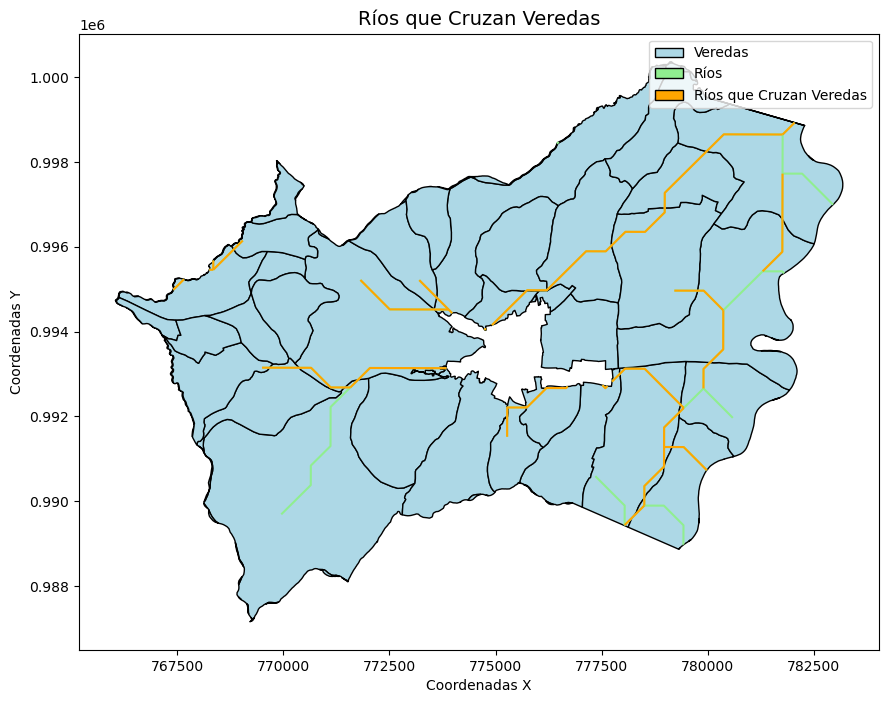

In [91]:
# Se carga el Geodataframe de veredas
gdf_veredas = gpd.read_file('/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Taller_1/Taller_Programacion_SIG/vector/LA_UNION_VEREDAS.gpkg')  # Capa 1
# Se carga el Geodataframe de rios
gdf_rios = gpd.read_file('/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Taller_1/Taller_Programacion_SIG/vector/LA_UNION_RIOS.gpkg')  # Capa 2

# Se filtran los rios que cruzan alguna vereda
gdf_crosses = gdf_rios[gdf_rios.geometry.apply(lambda geom: any(gdf_veredas.geometry.crosses(geom)))]

# Este mensaje muestra cuantos rios que cruzan veredas se encontraron
if gdf_crosses.empty:
    print("No se encontraron ríos que crucen las veredas.")
else:
    print(f"Se encontraron {len(gdf_crosses)} ríos que cruzan las veredas.")


# Se muestran resultados
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_veredas.plot(ax=ax, color='lightblue', edgecolor='black', label='Veredas')
gdf_rios.plot(ax=ax, color='lightgreen', edgecolor='black', label='Ríos')
gdf_crosses.plot(ax=ax, color='orange', edgecolor='black', label='Ríos que Cruzan Veredas')
ax.set_title('Ríos que Cruzan Veredas', fontsize=14)
ax.set_xlabel('Coordenadas X')
ax.set_ylabel('Coordenadas Y')
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='Veredas'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Ríos'),
    Patch(facecolor='orange', edgecolor='black', label='Ríos que Cruzan Veredas'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
plt.show()


### 5.2.7. Spatial Operations on raster data

- Clip a raster dataset (e.g., elevation, NDVI) to the extent of a vector layer such as administrative boundaries or study area.

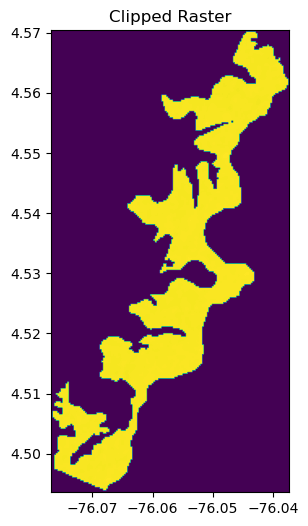

In [92]:
# Se carga el poligono que va a recortar al raster
unidad = gpd.read_file("/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Taller_1/Taller_Programacion_SIG/vector/unidad_cartografica/unidad_cartografica.shp")

# Se carga el archivo raster
raster_path = "/Users/jorgeandresjolahernandez/Desktop/Programacion SIG/Taller_1/Taller_Programacion_SIG/rasters/elevation.tif"
with rasterio.open(raster_path) as src:
    # Se igualan tipo de coordenadas
    if unidad.crs != src.crs:
        unidad = unidad.to_crs(src.crs)

    geometries = unidad["geometry"]
    # Se recorta el raster con el poligono
    clipped_raster, clipped_transform = mask(src, geometries, crop=True)

    # Se actualizan los metadatos del raster recortado
    clipped_meta = src.meta.copy()
    clipped_meta.update({
        "driver": "GTiff",
        "height": clipped_raster.shape[1],
        "width": clipped_raster.shape[2],
        "transform": clipped_transform
    })
    # Se visualiza raster recortado
    plt.figure(figsize=(10, 6))
    plt.title("Clipped Raster")
    show(clipped_raster[0], transform=clipped_transform, cmap="viridis")
    plt.show()


- Transform a raster dataset to the CRS of a vector layer or another spatial dataset.

In [153]:
# Se carga la capa vectorial
unidad = gpd.read_file("vector/unidad_cartografica/unidad_cartografica.shp")

# Se carga el raster
raster_path = "rasters/elevation.tif"
with rasterio.open(raster_path) as src:
    # Se obtiene el CRS de la capa vectorial
    vector_crs = unidad.crs

    # Se verific si el CRS del raster y el vector coinciden
    if src.crs != vector_crs:
        transform, width, height = calculate_default_transform(
            src.crs, vector_crs, src.width, src.height, *src.bounds
        )
        
        # Se reproyecta el raster al CRS del vector
        reproject(
            source=rasterio.band(src, 1),  
            destination=np.zeros((height, width), dtype=np.float32),  
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=vector_crs,
            resampling=Resampling.nearest 
        )
        output_raster_path = "rasters/reprojected_elevation.tif"
        with rasterio.open(output_raster_path, "w", driver="GTiff", count=1, dtype="float32", 
                           crs=vector_crs, transform=transform, width=width, height=height) as dst:
            dst.write(np.zeros((height, width), dtype=np.float32), 1)  # Escribir la matriz vacía
            print(f"Raster reproyectado guardado en: {output_raster_path}")

Raster reproyectado guardado en: rasters/reprojected_elevation.tif


- Calculate the mean or sum of raster values for each polygon in a vector dataset.

In [125]:
# Se carga informacion vectorial de veredas
vector_data = gpd.read_file('vector/corregimientos_la_union/corregimientos_la_union.shp')

# Se carga informacion raster de elevacion
raster = rasterio.open('rasters/elevation.tif')


# Se establece el mismo sistema de coordenadas
if vector_data.crs != raster.crs:
    vector_data = vector_data.to_crs(raster.crs)




# Se crea funcion para calcular valores raster para cada poligono
def calculate_raster_stats(vector_data, raster):
    results = []
    
    for idx, row in vector_data.iterrows():
        # Se obtiene la geometria de los poligonos vector
        geom = [row['geometry']]

        # Se enmascara el raster usando los poligonos extraidos
        out_image, out_transform = mask(raster, geom, crop=True)
        

        # Se eliminan valores nulos
        out_image = out_image[out_image != raster.nodata]
        
        # Se calcula la media y la suma de valores
        mean_value = np.mean(out_image)
        sum_value = np.sum(out_image)
        
        # Se unen las cabeceras con sus resultados
        results.append({'Cabecera': row['NOM_DIV_PO'], 'mean': mean_value, 'sum': sum_value})
    
    return results

# Se muestran los resultados
stats = calculate_raster_stats(vector_data, raster)
stats

[{'Cabecera': 'Cabecera Municipal', 'mean': 476.1429144921718, 'sum': 4744288},
 {'Cabecera': 'San Luis', 'mean': 445.77955646031893, 'sum': 28905238},
 {'Cabecera': 'Lindero', 'mean': 523.0502392344498, 'sum': 16397625},
 {'Cabecera': 'La Union', 'mean': 424.09969853574506, 'sum': 3939038},
 {'Cabecera': 'Quebrada Grande', 'mean': 589.3049164208456, 'sum': 23972924},
 {'Cabecera': 'La Despensa', 'mean': 823.0757693922851, 'sum': 41159550},
 {'Cabecera': 'Aguadas', 'mean': 350.33002905705985, 'sum': 27247969},
 {'Cabecera': 'Corcega', 'mean': 374.80427302302303, 'sum': 11981743}]

- Identify polygons with maximum or minimum values in the raster dataset.

### What challenges could arise when calculating zonal statistics for irregular or very small polygons?
Some challenges when calculating zonal statistics may present edge effects that distort the results, since these polygons usually cover few raster cells, data sparsity and computational complexity increase, since algorithms designed for larger areas may not be efficient for small geometries, in complex geometries may complicate the calculation and require additional preprocessing, if the raster data have high spatial variability, the small polygons may not adequately reflect the real conditions of the analyzed area

- Combine raster layers using mathematical operations to generate an index (e.g., suitability combining NDVI, slope, and distance to roads).

In [129]:

# Se crea una funci´pn para extraer valores maximos y minimos
def find_polygons_with_extreme_values(vector_data, raster, extreme='max'):
    # Se crea una ista para almacenar los valores
    extreme_values = []  
    # -np.inf para valor minimo y np.inf para valor maximo
    extreme_value = -np.inf if extreme == 'max' else np.inf
    # Variable donde se va a guardar el valor extermo encontrado
    extreme_polygon = None

    # Se itera sobre cada uno de los poligonos del archivos vector
    for idx, row in vector_data.iterrows():
        # Se obtiene la geometria
        geom = [row['geometry']]

        # Se enmascara el rasster que solo tenga valores para el poligono actual
        out_image, out_transform = mask(raster, geom, crop=True)
        
        # Se eliminan valores sin datos
        out_image = out_image[out_image != raster.nodata]

        # Si se encuentra un valor mas extremo la lista es actualizada y continua la iteracion
        current_extreme_value = np.max(out_image) if extreme == 'max' else np.min(out_image)
        if (extreme == 'max' and current_extreme_value > extreme_value) or (extreme == 'min' and current_extreme_value < extreme_value):
            extreme_value = current_extreme_value
            extreme_polygon = {'polygon_id': row['NOM_DIV_PO'], 'extreme_value': extreme_value}
    
    return extreme_polygon

# Se aplica la funcion para hayar el maximo
extreme_polygon_max = find_polygons_with_extreme_values(vector_data, raster, extreme='max')
print("Poligono con valor maximo:", extreme_polygon_max)
# Se aplica la funcion para hayar el minimo
extreme_polygon_min = find_polygons_with_extreme_values(vector_data, raster, extreme='min')
print("Poligono con valor minimo:", extreme_polygon_min)

Poligono con valor maximo: {'polygon_id': 'La Despensa', 'extreme_value': 2003}
Poligono con valor minimo: {'polygon_id': 'Cabecera Municipal', 'extreme_value': 0}


### How does resampling affect the accuracy and usefulness of your analysis?

Resampling can significantly impact the accuracy and utility of raster analysis, especially when combining multiple layers to generate an index such as suitability based on NDVI, slope, and distance to roads. When raster layers are re-sampled, the original spatial resolution is altered, which can result in loss of detail and accuracy in the data. For example, if a high resolution NDVI layer is resampled to match a lower resolution slope layer, important variations in vegetation health may be obscured, resulting in less reliable suitability assessments. In addition, the choice of re-sampling method (e.g., nearest neighbor, bilinear interpolation) may introduce biases; for example, nearest neighbor may better preserve categorical data, but may not accurately represent continuous data trends. Consequently, inappropriate resampling can lead to misleading conclusions about terrain suitability, making it essential to carefully consider the implications of resampling techniques in raster calculations.

- Perform a smoothing operation using a moving window (e.g., 3x3 kernel) to reduce noise in a raster dataset.

In [ ]:
raster = rasterio.open('rasters/elevation.tif')
def smooth_raster(raster, output_path, kernel_size=3):
    # Read the raster file
    with rasterio.open(raster_path) as src:
        # Read the data into a numpy array
        raster_data = src.read(1)  # Assuming single-band raster (use read() for multi-band)

        # Create a kernel for smoothing (3x3 averaging filter by default)
        kernel = np.ones((kernel_size, kernel_size), dtype=float) / (kernel_size * kernel_size)

        # Apply convolution (smoothing) using the kernel
        smoothed_data = convolve(raster_data, kernel, mode='reflect')

        # Write the smoothed data to a new raster
        profile = src.profile
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(smoothed_data, 1)

    print(f"Smoothed raster saved to {output_path}")

# Example usage:
smooth_raster(raster, "rasters/smoothed_raster.tif", kernel_size=3)

Smoothed raster saved to rasters/smoothed_raster.tif


### How does the size of the focal window (e.g., 3x3 vs 5x5) affect the results?
The size of the focal window, such as a 3x3 versus a 5x5 kernel, directly influences the smoothing results of a raster data set. A larger window, such as 5x5, tends to provide a greater smoothing effect by averaging more adjacent cells, which can help reduce noise and abrupt variations in the data. However, this can also lead to a loss of important details in the landscape structure, as features that might be relevant to the analysis are smoothed out.

### Why might you use a focal mean (smoothing) versus a focal maximum (highlighting peaks)?
The choice between using a focal mean (smoothing) or a focal maximum (peak highlighting) depends on the objectives of the analysis. Using the focal mean is useful for smoothing data and removing noise, which is ideal for obtaining a clearer representation of general trends in the data set. On the other hand, applying a focal maximum is beneficial when you want to highlight prominent features or peaks in the data, such as high areas or specific points of interest. In summary, the selection of the window size and type of focal operation should be aligned with the specific objectives of the raster analysis.

- Derive slope and aspect from a Digital Elevation Model (DEM) .

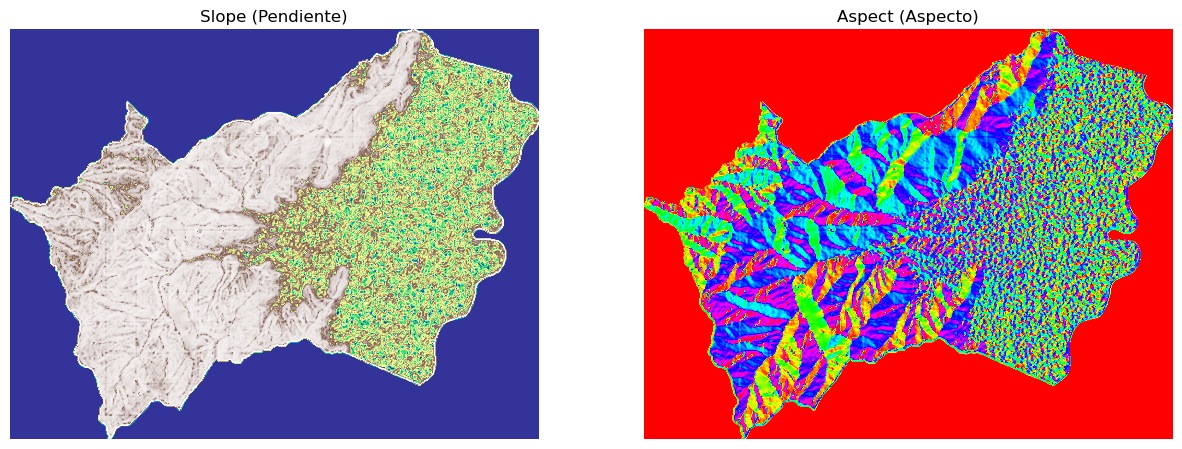

In [171]:
# Ruta del archivo DEM
dem_path = f"rasters/elevation.tif"

with rasterio.open(dem_path) as src:
    # Se lee la banda de elevacion
    dem = src.read(1)  

# Se calcula la pendiente utilizando la función de derivada de numpy
dx, dy = np.gradient(dem)

# Se calcula la pendiente (ángulo) en grados
slope = np.arctan(np.sqrt(dx**2 + dy**2)) * (180 / np.pi)

# Se calcula el aspecto en grados
aspect = np.arctan2(dy, dx) * (180 / np.pi)
aspect[aspect < 0] += 360  

# Se grafica la pendiente y el aspecto
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Se grafica la pendiente
ax[0].imshow(slope, cmap='terrain')
ax[0].set_title("Slope (Pendiente)")
ax[0].axis('off')

# Se grafica el aspecto
ax[1].imshow(aspect, cmap='hsv') 
ax[1].set_title("Aspect (Aspecto)")
ax[1].axis('off')

plt.show()

- Mask a raster dataset using zones to extract only specific regions.

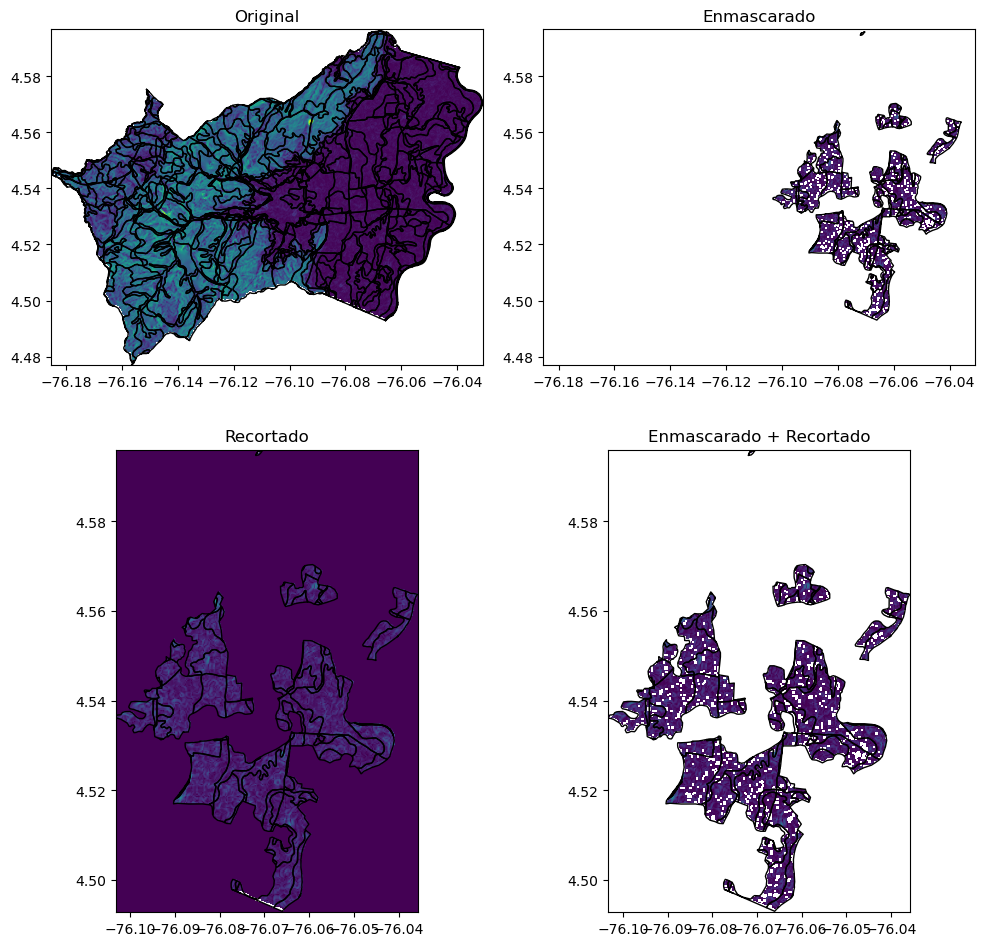

In [152]:
# Importar datos vectoriales
gdf_IDEAM = gpd.read_file('vector/LA_UNION_VALLE.gpkg')

# Importar el ráster
with rasterio.open('rasters/slope.tif') as src:
    slope_raster = src.read(1)
    raster_crs = src.crs  # Sistema de coordenadas del ráster
    raster_transform = src.transform
    raster_meta = src.meta

# Verificar y alinear proyecciones
if gdf_IDEAM.crs != raster_crs:
    gdf_IDEAM = gdf_IDEAM.to_crs(raster_crs)  # Reproyectar datos vectoriales

# Filtrar las geometrías por el atributo 'leyenda' con valor "2.4.1. Mosaico de cultivos"
gdf_filtrado = gdf_IDEAM[gdf_IDEAM['leyenda'] == "2.4.1. Mosaico de cultivos"]
if not gdf_filtrado.empty:
    geometries = [json.loads(gdf_filtrado.to_json())['features'][i]['geometry'] for i in range(len(gdf_filtrado))]

    # Enmascarar el ráster con la categoría filtrada
    with rasterio.open('rasters/slope.tif') as src:
        slope_raster_mask_crop, out_transform_crop = mask(src, geometries, crop=True)  # Masked + Cropped exact
        slope_raster_mask = mask(src, geometries, crop=False)[0]  # Solo enmascarado sin recortar
        out_meta = src.meta.copy()

    # Actualizar metadatos
    out_meta.update({"driver": "GTiff",
                     "height": slope_raster_mask_crop.shape[1],
                     "width": slope_raster_mask_crop.shape[2],
                     "transform": out_transform_crop})

    # Guardar el ráster enmascarado
    output_path = 'rasters/slope_masked_MosaicoCultivos_exact.tif'
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(slope_raster_mask_crop)

    # Generar salidas gráficas con mejor diferenciación
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Original
    rasterio.plot.show(slope_raster, transform=raster_transform, ax=axes[0, 0])
    gdf_IDEAM.plot(ax=axes[0, 0], color='none', edgecolor='black')
    axes[0, 0].set_title("Original")

    # Enmascarado 
    masked_array = np.ma.masked_where(slope_raster_mask == 0, slope_raster_mask)
    rasterio.plot.show(masked_array, transform=raster_transform, ax=axes[0, 1])
    gdf_filtrado.plot(ax=axes[0, 1], color='none', edgecolor='black')
    axes[0, 1].set_title("Enmascarado")

    # Recortado
    rasterio.plot.show(slope_raster_mask_crop, transform=out_transform_crop, ax=axes[1, 0])
    gdf_filtrado.plot(ax=axes[1, 0], color='none', edgecolor='black')
    axes[1, 0].set_title("Recortado")

    # Enmascarado + Recortado
    masked_crop_array = np.ma.masked_where(slope_raster_mask_crop == 0, slope_raster_mask_crop)
    rasterio.plot.show(masked_crop_array, transform=out_transform_crop, ax=axes[1, 1])
    gdf_filtrado.plot(ax=axes[1, 1], color='none', edgecolor='black')
    axes[1, 1].set_title("Enmascarado + Recortado")

    plt.tight_layout()
    plt.show()

else:
    print("No se encontraron geometrías con la leyenda '2.4.1. Mosaico de cultivos'")

    fig, ax = plt.subplots(figsize=(5, 5))
    rasterio.plot.show(slope_raster, transform=raster_transform, ax=ax)
    gdf_IDEAM.plot(ax=ax, color='none', edgecolor='black')
    plt.title("Original (Sin Filtrar)")
    plt.show()

- Gather two or more raster files with partial overlaps or adjacent coverage.

### What are the advantages of merging rasters into a single layer versus processing them separately?
When you have multiple rasters that you want treated as a single item, such as calculating the same statistics for all images, or when color balancing, we don't need to give treatment to each raster image separately. This is useful when working with imagery stored as separate tiles or bands. By doing this, the bands are treated as part of the same image, saving time and avoiding future entanglements.

- Clip the merged raster to a specific area of interest (e.g., a study region) using vector data.

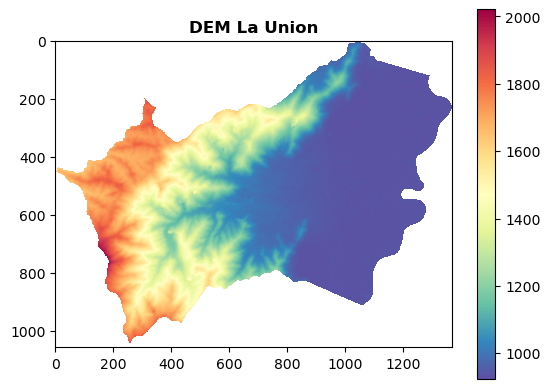

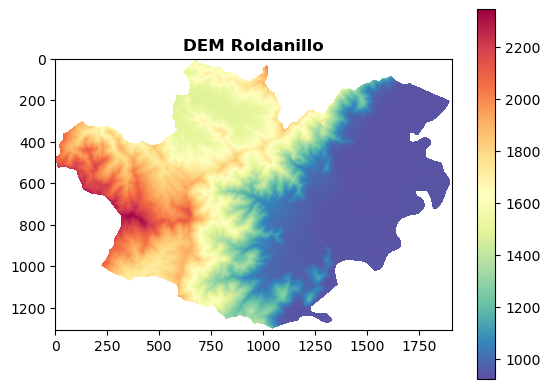

In [161]:
# Se cargan los DEM ráster del munipio de La Unión y Roldanillo 
dem_union = rasterio.open('rasters/dem_union.tif')
dem_rold = rasterio.open('rasters/dem_roldanillo.tif')

# Mapa de alruras sobre el nivel del mar La Unión
dem_u = dem_union.read(1).astype(float)
dem_u[dem_u == dem_union.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(dem_union, cmap='Spectral_r', ax=ax, title = 'DEM La Union')
fig.colorbar(ax.imshow(dem_u, cmap='Spectral_r'), ax=ax);

# Mapa de alruras sobre el nivel del mar Roldanillo
dem_r = dem_rold.read(1).astype(float)
dem_r[dem_r == dem_union.nodata] = np.nan
fig, ax = plt.subplots()
rasterio.plot.show(dem_rold, cmap='Spectral_r', ax=ax, title = 'DEM Roldanillo')
fig.colorbar(ax.imshow(dem_r, cmap='Spectral_r'), ax=ax);



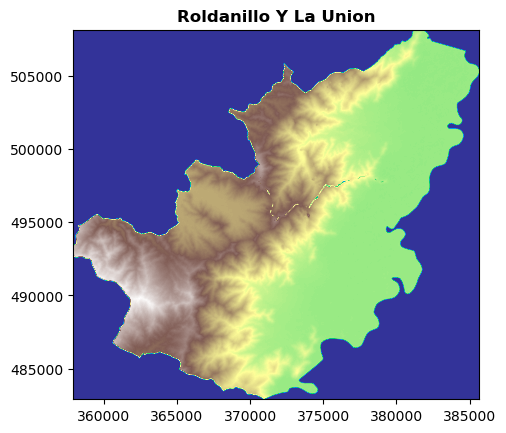

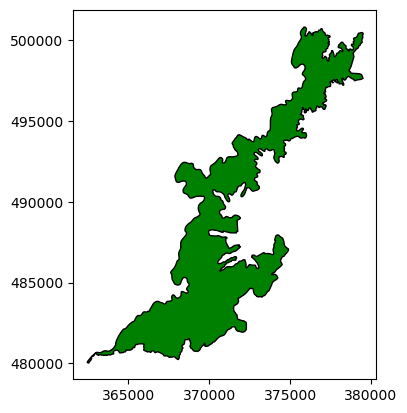

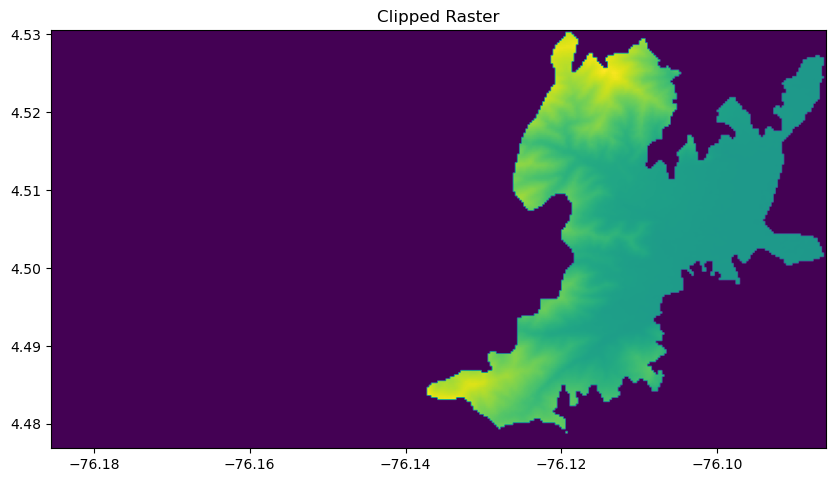

In [166]:
# Mediante la función .merge se unen las dos capas ráster
out_image, out_transform = rasterio.merge.merge([dem_union, dem_rold])
rasterio.plot.show(out_image, transform = out_transform, title = 'Roldanillo Y La Union', cmap = 'terrain');

# Se descarga la nueva capa ráster en formato.TIF 
out_meta = src.meta
with rasterio.open("rasters/merged_1.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Se carga la capa vectorial de área protegida 
path_shp_protec="vector/area_protec/area_protec.shp"
df_protec = gpd.read_file(path_shp_protec)

# Se reproyecta al CRS de la capa ráster creada
df_protec_new = df_protec.to_crs(epsg = 32618)
shape_1 = [df_protec_new['geometry']]
df_protec_new.crs

# Mapa capa vectorial
base = df_protec_new.plot(color='green', edgecolor='black');

# Se hace el recorte tomando como máscara la capa vectorial de área protegida

merged_1 = "rasters/merged_1.tif"
with rasterio.open(merged_1) as src:
    if df_protec_new.crs != src.crs:
        df_protec_new = df_protec_new.to_crs(src.crs)

    geometries = df_protec_new["geometry"]

    clipped_raster_1, clipped_transform_1 = mask(src, geometries, crop=True)
    clipped_meta_1 = src.meta.copy()
    clipped_meta_1.update({
        "driver": "GTiff",
        "height": clipped_raster_1.shape[1],
        "width": clipped_raster_1.shape[2],
        "transform": clipped_transform_1
    })

# Mapa de la capa recortada    
    plt.figure(figsize=(10, 6))
    plt.title("Clipped Raster")
    show(clipped_raster_1[0], transform = clipped_transform_1, cmap="viridis")
    plt.show()

# Se descarga la capa ráster recortada
with rasterio.open("rasters/clipped_1.tif", "w", **out_meta) as dest:
    dest.write(out_image)


### How do choices in preprocessing (e.g., clipping, reprojection, resampling) impact the final results of your analysis?
By doing preprocessing activities, the available information is organized properly, and it will be possible to save time and help the coded work better. For example, when we resampling, it often improves the overall accuracy and estimates any uncertainty within a set of information. It is usual that when we find geographic information, we do not find this information exactly from our research area, and the raster data is too weighted. By clipping according to the area we need, the information will be easily managed. Reprojection is also a very important process, as the information acquired is usually with different coordinate systems. If information is not at the same CSR, the code will give errors, and the analysis won’t take place.

### How would you prioritise different raster operations in a workflow where computational resources are limited?
The operations of raster analysis available when doing spatial analysis using python can be divided into five types: Local operations on single cells, focal operations on cell locations considering  neighborhoods, zonal operations on cell locations within zones, and global operations working on all cells in the raster. Once the data is decomposed appropriately, each piece of data can be operated independently by a process without the need to communicate with other processes. It is important to begin with cell by cell operations, as these are the simplest to parallelize, since the resulting value at each cell only depends on the input value at that cell location. When performing a geoprocessing workflow a good approach is to chain together the tools needed to perform the geospatial analysis and execute them serially.